MapD provides robust backend services for querying and rendering large datasets.  Jupyter can communicate with the MapD backend using either pymapd or the browser-connector.js provided by mapd.  The browser-connector is the how MapD drives their built in immerse visualization. pymapd provides access to cursors and datastreams connected to a distributed backend can interface mapd with distributed Python visualization and modeling tools.  

The browser-connector provides connectors to everything that the immerse UI can do.  This tool can be used within a widget or jupyter extension.

# Logo

Include a mapd logo in the DataFrames to differentiate from canonical DataFrames.

In [1]:
    _logo = """<img src="https://www.mapd.com/contentassets/108b327197514c99ba2fedf8e661f7e5/mapd-logo.svg"  width="32" />"""
    logo = f"""<a href="https://mapd.com">{_logo}</a>"""

# MapD settings

In [2]:
    immerse = {   
        'user': "mapd", 'password': "HyperInteractive", 'host': "192.168.99.100",
        'port': 32769, 'dbname': "mapd", 'protocol': 'binary', 
    }
    ui_port = 327768

In [3]:
    from ipywidgets import *
    __file__ = globals().get('__file__', 'two.ipynb')
    import pymapd
    from pymapd import Connection, Cursor
    from pandas import *
    from pandas import concat as Concat
    import typing as t
    from toolz.curried import *
    from toolz.curried.operator import *
    dunder = "__%s__"
    from dataclasses import dataclass, field
    from IPython.display import HTML

There are a lot of dataframes and we specify which that this dataframe enters `mapd`.

In [4]:
    def with_logo(str) -> str:
        return str.replace("<th></th>", """<th>{}</th>""".format(logo), 1)+"""
                <div>View in <a href="http://192.168.99.100:32770/">{logo} immerse</a></div>""".format(host=immerse['host'], logo=_logo, ui_port=ui_port)

In [5]:
    class BrandedFrame(DataFrame):
        @property
        def _constructor(DataFrame): return DataFrame
        
        def to_html(self, *args, **kwargs): return with_logo(super().to_html(*args, **kwargs))

In [6]:
    @dataclass
    class MapD(pymapd.Connection):
        _exclude_args = 'df', 'tables'
        
        uri: str= None  
        user: str = "mapd"
        password: str = field(default="HyperInteractive", repr=False)
        host: str = None
        port: int = None
        dbname: str = "mapd"
        protocol: str = field(default='binary', repr=False)
            
        tables: list = field(default_factory=list, metadata="""
        A list of table names to load 
        """)

        df: BrandedFrame = field(default_factory=BrandedFrame, repr=False, metadata="""
        A DataFrame storing the table information. This object is useful repr for a mapd connection.""")
        
        def __post_init__(Connection):
            super().__init__(**{str: getattr(Connection, str) 
                                for str in Connection.__dataclass_fields__
                                if str not in Connection._exclude_args})
            Connection.populate(tables=Connection.tables)
            get_ipython().register_magic_function(compose(
                itemgetter(slice(None, 10)), Connection
            ), 'cell', 'mapd')
            
            
        def populate(Connection, tables=None):     
            if tables is not None: tables = Connection.tables = Series(Connection.get_tables())
                
            Connection.df = Concat({
                str: DataFrame([object._asdict() for object in Connection.get_table_details(str)])
                for str in list(tables)
            }).reset_index(-1, drop=True).pipe(Connection.df.append).pipe(BrandedFrame)
            
        def tables(Connection): return Series(Connection.get_tables())

        @property
        def __getitem__(Connection): return Connection.df.loc.__getitem__

        def _repr_mimebundle_(Connection, **kwargs):
            return {
                'text/plain': repr(Connection.df),                
                'text/html': Connection.df.to_html()
            }, {'mapd': {'dbname': repr(Connection),}}

        def __getitem__(Connection, str): return MapD([
            {key: getattr(object, key) for key in object._fields}
            for object in Connection.get_table_details(str)])

        def __call__(Connection, *strs):
            with Connection as connect:
                return connect.execute('\n'.join(strs))

In [7]:
    @partial(setattr, Cursor, '_repr_mimebundle_')
    def _repr_mimebundle_(Cursor, **kwargs):
        # Need to add the column names.
        return {
            'text/plain': repr(Cursor),
            'text/html': BrandedFrame(list(take(10, Cursor.result_set)), columns=[object.name for object in Cursor.description]).to_html()
        }, {}
    
    @partial(setattr, Cursor, '__getitem__')
    def __getitem__(Cursor, object):
        if isinstance(object, int):
            return first(take(1, drop(object, Cursor.result_set)))
        if isinstance(object, slice):
            start, stop, step = attrgetter('start', 'stop', 'step')(object)
            start = start or 0
            iter = drop(start, Cursor.result_set)
            if step:
                iter = take_nth(step, iter)
            
            if stop:
                iter = take((stop-start)//(step or 1), iter)
                
            return DataFrame(list(iter), columns=[object.name for object in Cursor.description])

In [8]:
    mapd = MapD(**immerse)
    mapd

,name,type,nullable,precision,scale,comp_param
flights,c1_Year,SMALLINT,True,0,0,0
flights,c2_Month,SMALLINT,True,0,0,0
flights,DayofMonth,SMALLINT,True,0,0,0
flights,DayOfWeek,SMALLINT,True,0,0,0
flights,DepTime,STR,True,0,0,32
flights,CRSDepTime,SMALLINT,True,0,0,0
flights,ArrTime,STR,True,0,0,32
flights,CRSArrTime,SMALLINT,True,0,0,0
flights,UniqueCarrier,STR,True,0,0,32
flights,FlightNum,SMALLINT,True,0,0,0


In [23]:
    mapd('select * from iris')

,c1,sepal_length__cm,sepal_width__cm,petal_length__cm,petal_width__cm
0,setosa,5.1,3.5,1.4,0.2
1,setosa,4.9,3.0,1.4,0.2
2,setosa,4.7,3.2,1.3,0.2
3,setosa,4.6,3.1,1.5,0.2
4,setosa,5.0,3.6,1.4,0.2
5,setosa,5.4,3.9,1.7,0.4
6,setosa,4.6,3.4,1.4,0.3
7,setosa,5.0,3.4,1.5,0.2
8,setosa,4.4,2.9,1.4,0.2
9,setosa,4.9,3.1,1.5,0.1


In [10]:
    %%mapd
    select * from iris

,c1,sepal_length__cm,sepal_width__cm,petal_length__cm,petal_width__cm
0,setosa,5.1,3.5,1.4,0.2
1,setosa,4.9,3.0,1.4,0.2
2,setosa,4.7,3.2,1.3,0.2
3,setosa,4.6,3.1,1.5,0.2
4,setosa,5.0,3.6,1.4,0.2
5,setosa,5.4,3.9,1.7,0.4
6,setosa,4.6,3.4,1.4,0.3
7,setosa,5.0,3.4,1.5,0.2
8,setosa,4.4,2.9,1.4,0.2
9,setosa,4.9,3.1,1.5,0.1


# Idiomatic API Features

The call method transparently executes queries.

We define custom representations of the data.

## Each query is immutable

In [24]:
    query = mapd('select * from iris')
    query[:10]

,c1,sepal_length__cm,sepal_width__cm,petal_length__cm,petal_width__cm
0,setosa,5.1,3.5,1.4,0.2
1,setosa,4.9,3.0,1.4,0.2
2,setosa,4.7,3.2,1.3,0.2
3,setosa,4.6,3.1,1.5,0.2
4,setosa,5.0,3.6,1.4,0.2
5,setosa,5.4,3.9,1.7,0.4
6,setosa,4.6,3.4,1.4,0.3
7,setosa,5.0,3.4,1.5,0.2
8,setosa,4.4,2.9,1.4,0.2
9,setosa,4.9,3.1,1.5,0.1


In [34]:
    query[:10]

,c1,sepal_length__cm,sepal_width__cm,petal_length__cm,petal_width__cm
0,virginica,6.3,3.3,6.0,2.5
1,virginica,5.8,2.7,5.1,1.9
2,virginica,7.1,3.0,5.9,2.1
3,virginica,6.3,2.9,5.6,1.8
4,virginica,6.5,3.0,5.8,2.2
5,virginica,7.6,3.0,6.6,2.1
6,virginica,4.9,2.5,4.5,1.7
7,virginica,7.3,2.9,6.3,1.8
8,virginica,6.7,2.5,5.8,1.8
9,virginica,7.2,3.6,6.1,2.5


MapD immerse can only create images on the backend when gpu is enabled.  But, we can apply any python visualization to query stream.

    query[:] means get all the data.

Mapd to pandas

In [35]:
    df = mapd('select * from iris')[:]

Plot the mapd with scipy tooling.

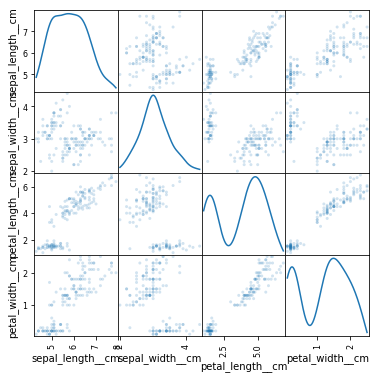

In [36]:
    %matplotlib inline
    mapd('select * from iris')[:].set_index('c1').pipe(
        plotting.scatter_matrix, alpha=0.2, figsize=(6, 6), diagonal='kde');

# Jupyter widget can interact with mapd

We can create a basic sql query editor with IPython widgets.  The mapd immmerse sql editor reminds me of a notebook.

In [15]:
    from ipywidgets import HTML as HTMLwidget
    from traitlets import dlink

In [20]:
    Query = Textarea(description='SQL query', value="select * from iris")
    Max = IntText(value=10)
    Submit = Button(description="Submit query")
    Table = HTMLwidget()

    @Submit.on_click
    def update_table(object):
        Table.value = mapd(Query.value)[:Max.value].to_html()

In [22]:
    mapd = MapD(**immerse)
    VBox(children=[
        HBox(children=[
            Query
        ]),
        HBox(children=[
            Submit, Max
        ]),
        HBox(children=[
            Table
        ]),
        

    ])

VBox(children=(HBox(children=(Textarea(value='select sepal_length__cm, c1\n from iris', description='SQL query'),)), HBox(children=(Button(description='Submit query', style=ButtonStyle()), IntText(value=10))), HBox(children=(HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>sepal_length__cm</th>\n      <th>c1</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>5.1</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>4.9</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>4.7</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>4.6</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>5.0</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>5</th>\n      <td>5.4</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>6</th>\n      <td>4.6</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>7</th>\n      <td>5.0</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>8</th>\n      <td>4.4</td>\n      <td>setosa</td>\n    </tr>\n    <tr>\n      <th>9</th>\n      <td>4.9</td>\n      <td>setosa</td>\n    </tr>\n  </tbody>\n</table>'),))))